In [1]:
# PPO, https://spinningup.openai.com/en/latest/algorithms/ppo.html
# Pretty stable, but could be better

In [2]:
%pylab inline
import random
import time
import numpy as np

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Dense, Activation, Lambda

import gym

Populating the interactive namespace from numpy and matplotlib


In [3]:
#env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")
#env = gym.make("Pong-v0")
env.observation_space, env.action_space, type(env.action_space)

(Box(8,), Discrete(4), gym.spaces.discrete.Discrete)

In [5]:
# policy function
x =in_state = Input(env.observation_space.shape)
#state_in_tuple = (210*160*3,)
#x = in_state = Input(state_in_tuple)
x = Dense(32, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = Dense(env.action_space.n)(x)
action_dist = Lambda(lambda x: tf.nn.log_softmax(x, axis=-1))(x)
p = Model(in_state, action_dist)
pf = K.function(p.layers[0].input,
                [p.layers[-1].output,
                 tf.random.categorical(p.layers[-1].output, 1)[0]])

in_advantage = Input((1,))
in_old_prediction = Input((env.action_space.n,))
def loss(y_true, y_pred): 
  advantage = tf.reshape(in_advantage, (-1,))
  
  # y_pred is the log probs of the actions
  # y_true is the action mask
  prob = tf.reduce_sum(y_true * y_pred, axis=-1)
  old_prob = tf.reduce_sum(y_true * in_old_prediction, axis=-1)
  ratio = tf.exp(prob - old_prob)  # hehe, they are log probs, so we subtract
  
  # this is the VPG objective
  #ll = -(prob * advantage)
  
  # this is PPO objective
  ll = -K.minimum(ratio*advantage, K.clip(ratio, 0.8, 1.2)*advantage)
  return ll

popt = Model([in_state, in_advantage, in_old_prediction], action_dist)
popt.compile(Adam(5e-4), loss)
popt.summary()

# value function
x = in1 = Input(env.observation_space.shape)
x = Dense(32, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = Dense(1)(x)
v = Model(in1, x)
v.compile(Adam(1e-3), 'mse')
v.summary()

vf = K.function(v.layers[0].input, v.layers[-1].output)

gamma = 0.99
lll = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
_________________________________________________________________
lambda (Lambda)              (None, 4)                 0         
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________
Instruct

In [6]:
import tensorflow as tf
print(tf.__version__)

1.13.0-rc0


In [11]:
for epoch in range(100):
  st = time.perf_counter()
  
  X,Y,V,P = [],[],[],[]
  ll = []
  while len(X) < 8192:
    obs = env.reset()
    #print(obs.shape)
    #print(type(obs.reshape(1,-1)))
    #print(obs.reshape(1,-1).shape)
    #obs_ = obs.reshape(-1,1)
    #print(obs.shape)
    #print(obs_.shape)
    #obs_1 = np.ravel(obs_)
    #print(obs_1.shape)
    
    rews = []

    while True:
      # get the action
      #pred, act = [x[0] for x in pf(obs_1[None])]
      pred, act = [x[0] for x in pf(obs[None])]
      P.append(pred)
      
      # save this state action pair
      X.append(np.copy(obs))
      act_mask = np.zeros((env.action_space.n))
      act_mask[act] = 1.0
      Y.append(act_mask)

      # take the action and save the reward
      obs, rew, done, _ = env.step(act)
      rews.append(rew)

      if done:
        ll.append(np.sum(rews))
        # computes rewards to go with gamma discounting
        for i in range(len(rews)-2, -1, -1):
          rews[i] += rews[i+1] * gamma
        V.extend(rews)
        break
  X,Y,V,P = [np.array(x) for x in [X,Y,V,P]]

  # subtract value baseline to get advantage
  A = V - vf(X)[:, 0]
  
  loss = popt.fit([X,A,P],Y, batch_size=1024, epochs=10, shuffle=True, verbose=0)
  loss = loss.history['loss'][-1]
  vloss = v.fit(X, V, batch_size=1024, epochs=10, shuffle=True, verbose=0)
  vloss = vloss.history['loss'][-1]
        
  lll.append((epoch, np.mean(ll), loss, vloss, len(X), len(ll), time.perf_counter() - st))
  print("%3d  ep_rew:%9.2f  loss:%7.2f   vloss:%9.2f  counts: %5d/%3d tm: %.2f s" % lll[-1])

  0  ep_rew:   231.91  loss:   9.25   vloss:   876.87  counts:  8318/ 32 tm: 6.62 s
  1  ep_rew:   259.55  loss:  -6.44   vloss:   725.20  counts:  8229/ 37 tm: 5.18 s
  2  ep_rew:   228.41  loss:   3.63   vloss:  1047.12  counts:  8223/ 40 tm: 5.02 s
  3  ep_rew:   238.34  loss:  -1.55   vloss:   630.29  counts:  8287/ 36 tm: 5.40 s
  4  ep_rew:   272.10  loss:  -4.01   vloss:   360.61  counts:  8262/ 34 tm: 5.41 s
  5  ep_rew:   244.67  loss:   8.25   vloss:   668.10  counts:  8397/ 40 tm: 5.15 s
  6  ep_rew:   239.94  loss:  -3.42   vloss:   573.04  counts:  8367/ 44 tm: 5.03 s
  7  ep_rew:   215.72  loss:   6.24   vloss:   968.86  counts:  8278/ 33 tm: 5.81 s
  8  ep_rew:   249.41  loss:  -9.42   vloss:   402.06  counts:  8240/ 32 tm: 5.77 s
  9  ep_rew:   259.32  loss:   5.83   vloss:   497.80  counts:  8347/ 36 tm: 5.19 s
 10  ep_rew:   240.70  loss:   8.04   vloss:   672.94  counts:  8308/ 37 tm: 5.55 s
 11  ep_rew:   259.53  loss:  -1.23   vloss:   624.63  counts:  8223/ 36 tm:

 98  ep_rew:   272.35  loss:   1.38   vloss:   223.43  counts:  8330/ 41 tm: 5.15 s
 99  ep_rew:   263.25  loss:   7.35   vloss:   381.81  counts:  8230/ 34 tm: 5.77 s


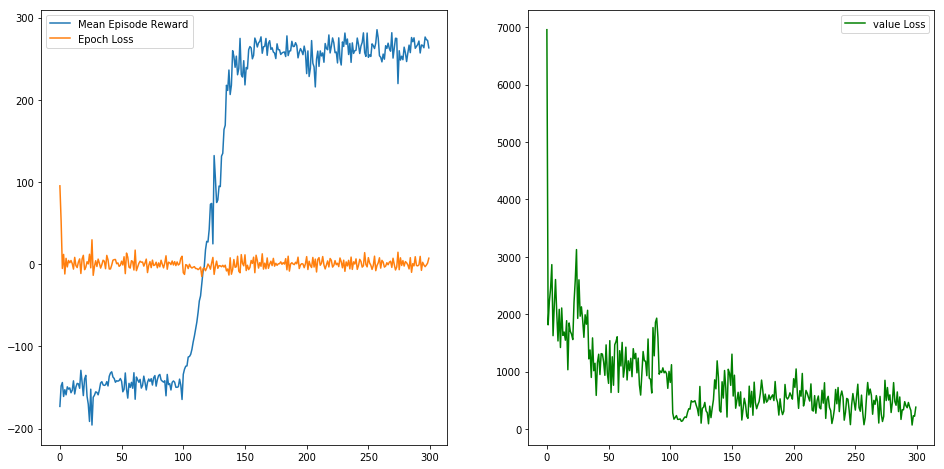

In [12]:
figsize(16,8)
plt.subplot(1,2,1)
plot([x[1] for x in lll], label="Mean Episode Reward")
plot([x[2] for x in lll], label="Epoch Loss")
plt.legend()
plt.subplot(1,2,2)
plot([x[3] for x in lll], color='green', label="value Loss")
plt.legend()

In [13]:
obs = env.reset()
rews = []
while True:
  env.render()
  pred, act = [x[0] for x in pf(obs[None])]
  obs, rew, done, _ = env.step(np.argmax(pred))
  rews.append(rew)
  time.sleep(0.05)
  if done:
    break
print("ran %d steps, got %f reward" % (len(rews), np.sum(rews)))

ran 208 steps, got 289.944525 reward
